## Modeling Heart Disease

Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn import (preprocessing, metrics)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_validate)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Read in the 'clean' data from EDA
(One duplicate, and one possible outlier dropped)

In [2]:
data = pd.read_csv('heart_clean.csv')

Normalize continuous data (z-score) so that feature values are on similar scales. (Categorical data values are already on similar scales, so do not require transformation at this time.) 
Split data into training/test sets so test data does not influence z-score normalization.

In [3]:
# Set random state for reproducibility 
random_seed = 20
# Style option for later graphs
sns.set_style('whitegrid')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(
    columns='target'),data.target, test_size=0.3, stratify=data.target, random_state=random_seed)

In [5]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [6]:
mapper = DataFrameMapper([([n], preprocessing.StandardScaler()) for n in numerical],
                         default=None, df_out=True)

In [7]:
X_train = mapper.fit_transform(x_train)
X_test = mapper.transform(x_test)

## Model 1: K-Nearest Neighbors
Predicts disease state based on votes from a defined number of nearest neighbors. <br> 
Parameters to be optimized by grid search: 1. k_neighbors - how many neighbors to count, 2. weights - whether or not to weight votes by distance, 3. metric - distance measure <br>


In [8]:
knn = KNeighborsClassifier()

In [9]:
params = {'n_neighbors': [i for i in range(1, 20, 2)], # skip even numbers to avoid ties
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

In [10]:
# f1 score is selected to measure a balance of precision and recall
# cv and iid are adjusted to match default behaviour of future version sklearn
model = GridSearchCV(knn, params, scoring='f1', return_train_score=True, cv=5, iid=False)

In [11]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

In [12]:
print('Best parameters:', model.best_params_)
print('Best score: {:.3f}'.format(model.best_score_))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.865


### Evaluate K-neighbors  parameter optimization and model performance

Plot the train/test results from grid search to evaluate how each of the parameters affected training, and check that the 'best parameters' are reasonable.

In [13]:
# Save selected results in molten form for graphing
res = pd.DataFrame.from_dict(model.cv_results_).melt(
    id_vars = ['param_n_neighbors', 'param_metric', 'param_weights'],
    value_vars = ['mean_test_score', 'mean_train_score'])

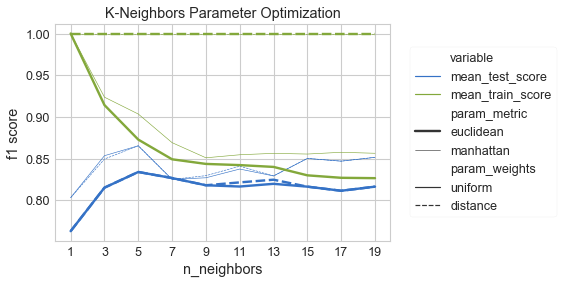

In [14]:
sns.lineplot(x = res.param_n_neighbors, y = res.value, size = res.param_metric,
             hue = res.variable, style = res.param_weights)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left") # move legend outide of grid
plt.xticks(range(1,20,2))
plt.ylabel('f1 score')
plt.xlabel('n_neighbors')
plt.title('K-Neighbors Parameter Optimization');

1. k_neighbors: The 'elbow' where the train and test scores converge appears around k=5-7 <br> 
2. weights: Test scores were hardly affected, but weighting by distance completely overestimated the training score, making 'uniform' a better choice. <br>
3. metric: Manhattan scores are consistently (slightly) higher than euclidean. However the euclidean curves are smooth, while manhattan are somewhat erratic, indicating they could be overfit. <br>
Overall, the parameters selected during training (k=5, weights=uniform, and metric=manhattan) appear reasonable.

The model was refit with the best parameters found during grid search, so can be used predict labels for test data and evaluate performance.

In [15]:
y_pred = model.predict(X_test)

In [16]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        42
           1       0.81      0.88      0.84        49

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



The classification report shows a breakdown of precision, recall, and f1-score (weighted average of precision and recall) for each label, as well as test accuracy, macro (unweighted), and weighted averages for each score. 'Support' is the number true occurrences for that label in the test data split. A confusion matrix can be plotted to visualize the number of correct/incorrect predictions for each label.

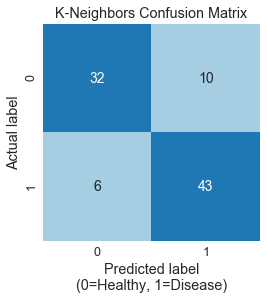

In [17]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('K-Neighbors Confusion Matrix');

Overall, precision and recall are fairly balanced. The model tends to over-predict presence of heart disease; it's worst-performing metric is recall for the negative ('healthy') label. However, this behavior may be preferable to the alternative, as the danger of **not** identifying a true case of heart disease is likely more severe for an ill patient than the risk of further (unnecessary) diagnostic tests for a healthy one. 

## Model 2: Linear Support Vector Classification
As suggested by the scikit-learn guide: [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [18]:
# dual=False is preferred when n_samples > n_features
# when dual=False, implementation is not random so do not need to set random_state
clf = LinearSVC(dual=False, verbose=1)

In [19]:
clf.fit(X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

Predict labels for test data, then evaluate model performance with classification report and confusion matrix.

In [20]:
c_pred = clf.predict(X_test)

In [21]:
print(metrics.classification_report(y_test, c_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        42
           1       0.84      0.94      0.88        49

    accuracy                           0.87        91
   macro avg       0.88      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



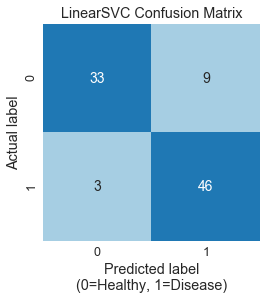

In [22]:
sns.heatmap(metrics.confusion_matrix(y_test, c_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('LinearSVC Confusion Matrix');

Performance for this model is a surprisingly large improvement over K-Neighbors...perhaps suspiciously good. Check cross validation scores to see if the model is overfit. 

In [23]:
clf_cv = cross_validate(clf, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [24]:
# Compare f1 scores from cross-validaton to the trained model
print('Average CV train score: {:.3f}'.format(clf_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(clf_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, clf.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, c_pred)))

Average CV train score: 0.865
Average CV test score: 0.851
Model train score: 0.867
Model test score: 0.885


The LinearSVC model is more accurate than the K-neighbors, with improved precision and recall for both 'healthy' and 'heart disease' labels. The model still tends towards type 1 error. <br>
One caveat is that the test score (f1 = 0.885) is higher than the model train score, and both of the cross-validation mean scores. I expect this is due to this particular train/test split. As the CV and model train scores are very similar, actual performance of the model would likely be in line with the cross-validation test score (~ 0.851). 

## Model 3: Random Forest

In [25]:
# n_estimators=100 to match default for future version of sklearn
rfc = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [26]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

Use trained classifier to predict labels for test data, and evaluate performance. 

In [27]:
r_pred = rfc.predict(X_test)

In [28]:
print(metrics.classification_report(y_test, r_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80        42
           1       0.82      0.86      0.84        49

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91



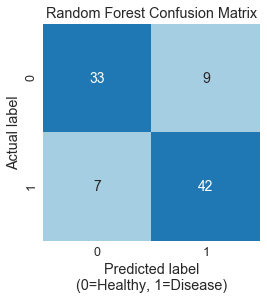

In [29]:
sns.heatmap(metrics.confusion_matrix(y_test, r_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('Random Forest Confusion Matrix');

Similar performance to K-neighbors classifier, with slightly higher type II error (false negatives). 

Calculate cross validation scores to assess how well the model is fit. 

In [30]:
rfc_cv = cross_validate(rfc, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

In [31]:
# Compare f1 scores from cross-validaton and the trained model
print('Average CV train score: {:.3f}'.format(rfc_cv['train_score'].mean()))
print('Average CV test score: {:.3f}'.format(rfc_cv['test_score'].mean()))
print('Model train score: {:.3f}'.format(metrics.f1_score(y_train, rfc.predict(X_train))))
print('Model test score: {:.3f}'.format(metrics.f1_score(y_test, r_pred)))

Average CV train score: 1.000
Average CV test score: 0.829
Model train score: 1.000
Model test score: 0.840


The perfect training scores indicate the model is overfit to the training data. Try reducing leaf depth to generalize the model. Use grid search to determin optimal depth. 

In [32]:
rfc_params = {'max_depth': [i for i in range(1, 21)]}

In [33]:
rfc_opt = GridSearchCV(rfc, param_grid=rfc_params, scoring='f1', cv=5, iid=False,
                       return_train_score=True)

In [34]:
rfc_opt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=20,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'max_

Check which value for depth was best, and see if model performance improved. 

In [35]:
print('Best parameters:', rfc_opt.best_params_)
print('Best score: {:.3f}'.format(rfc_opt.best_score_))

Best parameters: {'max_depth': 2}
Best score: 0.854


In [36]:
ro_pred = rfc_opt.predict(X_test)
print(metrics.classification_report(y_test, ro_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        42
           1       0.83      0.92      0.87        49

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91



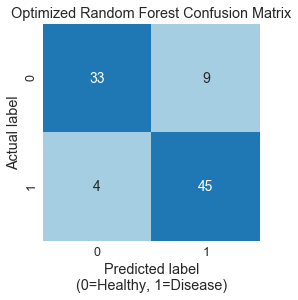

In [37]:
sns.heatmap(metrics.confusion_matrix(y_test, ro_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('Optimized Random Forest Confusion Matrix');

Reducing leaf depth improved performance to near that of LinearSVC. 

Plot mean cross-validation scores to see the effect of leaf depth on model fit. 

In [38]:
# Save selected results in molten form for graphing
r_res = pd.DataFrame.from_dict(rfc_opt.cv_results_).melt(
    id_vars = ['param_max_depth'],
    value_vars = ['mean_test_score', 'mean_train_score'])

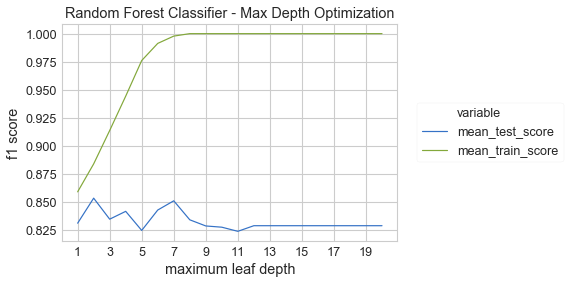

In [39]:
sns.lineplot(x = r_res.param_max_depth, y = r_res.value, hue = r_res.variable)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left") # move legend outide of grid
plt.xticks(range(1,20,2))
plt.ylabel('f1 score')
plt.xlabel('maximum leaf depth')
plt.title('Random Forest Classifier - Max Depth Optimization');

Train/test scores are the closest when max_depth=2. The training data is completely overfit once max_depth=7. A maximum leaf depth of 2 provides the best generalized fit. 